Cargamos todos los archivos que existen en la ruta indicada. No olvides tener tu archivo .env

In [20]:
import boto3
import pandas as pd
import json
from io import BytesIO
from dotenv import load_dotenv
import os

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Obtener las credenciales desde las variables de entorno
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

# Crear el cliente S3 usando las credenciales cargadas
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key
)

# Parámetros
bucket_name = 'agroproductoseba'
prefix = 'planta1/Logs/Electricidad/sin_duplicados/'  # por ejemplo: 'data/jsons/'

# Obtener la lista de objetos .json bajo ese prefijo
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Lista para almacenar los DataFrames
dfs = []
contador=0
# Iterar sobre los archivos
for obj in response.get('Contents', []):
    key = obj['Key']
    if key.endswith('.json'):
        # Descargar el archivo
        response = s3.get_object(Bucket=bucket_name, Key=key)
        content = response['Body'].read()
        contador=contador+1
        # Convertir JSON en DataFrame
        try:
            
            json_data = json.loads(content)
            # Asegúrate de que json_data sea lista o dict estructurado para pandas
            df = pd.json_normalize(json_data)
            dfs.append(df)
            print(f"cargando json:{contador}")
        except Exception as e:
            print(f"Error procesando {key}: {e}")

# Unir todos los DataFrames
final_df = pd.concat(dfs, ignore_index=True)

# Mostrar resultado
print(final_df.head())


cargando json:1
cargando json:2
cargando json:3
cargando json:4
cargando json:5
cargando json:6
cargando json:7
cargando json:8
cargando json:9
cargando json:10
cargando json:11
cargando json:12
cargando json:13
cargando json:14
cargando json:15
cargando json:16
cargando json:17
cargando json:18
cargando json:19
cargando json:20
cargando json:21
cargando json:22
cargando json:23
cargando json:24
cargando json:25
cargando json:26
cargando json:27
cargando json:28
cargando json:29
cargando json:30
cargando json:31
cargando json:32
cargando json:33
cargando json:34
cargando json:35
cargando json:36
cargando json:37
cargando json:38
cargando json:39
cargando json:40
cargando json:41
cargando json:42
cargando json:43
cargando json:44
cargando json:45
cargando json:46
cargando json:47
cargando json:48
cargando json:49
cargando json:50
cargando json:51
cargando json:52
cargando json:53
cargando json:54
cargando json:55
cargando json:56
cargando json:57
cargando json:58
cargando json:59
cargan

Imprimimos los primeros 5 registros para revisar la estructura de la Data

In [21]:
final_df.head(5)

,ID,ts,d.VBC,d.VAC,d.CC,d.VA,d.VB,d.kWh,d.CA,d.CB,d.VC,d.VAB
0,0018233caddb,2025-3-25 11:0:1,[232.66000366210938],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0018233caddb,2025-3-25 11:0:9,NaN,[233.6479949951172],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0018233caddb,2025-3-25 11:0:23,NaN,NaN,[0],[134.14999389648438],[132.125],[1216.3880615234375],NaN,NaN,NaN,NaN
3,0018233caddb,2025-3-25 11:0:24,NaN,NaN,NaN,NaN,NaN,NaN,[1.440000057220459],[3.940000057220459],NaN,NaN
4,0018233caddb,2025-3-25 11:0:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[136.38699340820312],NaN


Como puedes observar tendremos que limpiar la informacion, seguiremos los siguientes pasos
1.- Elimnamos la columna ID No nos sirve 
2.- Tendremos que hacer una agrupacion por time stamp veo conveniente que sea por minuto
3.- renombremos las columnas con el nombre adecuado


In [22]:
print(final_df.dtypes)  # Verifica los tipos de datos después de la conversión


ID       object
ts       object
d.VBC    object
d.VAC    object
d.CC     object
d.VA     object
d.VB     object
d.kWh    object
d.CA     object
d.CB     object
d.VC     object
d.VAB    object
dtype: object


In [23]:

# 1. Renombrar las columnas eliminando el prefijo 'd.' y eliminando la columna 'ID'
final_df = final_df.rename(columns=lambda x: x.replace('d.', '') if x != 'ID' else x)

# 2. Eliminar la columna 'ID'
final_df = final_df.drop(columns=['ID'])

# Verifica los cambios en las columnas
print(final_df.columns)


Index(['ts', 'VBC', 'VAC', 'CC', 'VA', 'VB', 'kWh', 'CA', 'CB', 'VC', 'VAB'], dtype='object')


In [24]:
final_df.head()

,ts,VBC,VAC,CC,VA,VB,kWh,CA,CB,VC,VAB
0,2025-3-25 11:0:1,[232.66000366210938],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-3-25 11:0:9,NaN,[233.6479949951172],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-3-25 11:0:23,NaN,NaN,[0],[134.14999389648438],[132.125],[1216.3880615234375],NaN,NaN,NaN,NaN
3,2025-3-25 11:0:24,NaN,NaN,NaN,NaN,NaN,NaN,[1.440000057220459],[3.940000057220459],NaN,NaN
4,2025-3-25 11:0:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[136.38699340820312],NaN


Es una lista cada registro

In [25]:
for column in final_df:
    if column =="ts":
        final_df[column] = final_df[column].apply(lambda x: x[0] if isinstance(x, list) else x)
        final_df[column] = pd.to_datetime(final_df[column], errors='coerce')

    else:
        final_df[column] = final_df[column].apply(lambda x: x[0] if isinstance(x, list) else x)
        # Convertir la columna a tipo flotante
        final_df[column] = pd.to_numeric(final_df[column], errors='coerce')


convertimos en indice el ts

In [26]:
final_df = final_df.set_index('ts')
final_df.dtypes



VBC    float64
VAC    float64
CC     float64
VA     float64
VB     float64
kWh    float64
CA     float64
CB     float64
VC     float64
VAB    float64
dtype: object

Los tipos de datos ya estan listos, ahora procedemos a normalizar el dataframe sampleo por minuto

In [27]:
df_resampled = final_df.resample('min').first()  # 'min' es el código para "minuto"

In [28]:
df_resampled.head(5)

,VBC,VAC,CC,VA,VB,kWh,CA,CB,VC,VAB
ts,,,,,,,,,,
2025-03-25 09:00:00,235.291000,236.373001,0.0,135.513000,133.339996,1215.535034,1.22,3.76,137.445007,233.057007
2025-03-25 09:01:00,235.919006,235.132996,0.0,135.755005,133.358002,1215.536011,1.18,3.38,138.016006,233.904999
2025-03-25 09:02:00,237.231003,236.559006,0.0,133.610001,133.723007,1215.539062,1.20,12.92,138.313995,231.112000
2025-03-25 09:03:00,236.639999,238.061005,0.0,134.134003,134.300003,1215.549072,1.22,12.06,138.824005,231.817001
2025-03-25 09:04:00,236.197006,237.403000,0.0,136.492996,134.289993,1215.554077,1.20,2.30,138.479996,234.570999


Aparentemente no encontramos nulos al hacer resampleo por minuto que es el que definimos en dopsoft. Busquemos valores faltantes

In [29]:
# Filtrar y mostrar las filas con al menos un NaN
nan_rows = final_df[final_df.isna().any(axis=1)]

# Mostrar las filas con valores NaN
print("Filas con registros NaN:")
print(nan_rows)

Filas con registros NaN:
                            VBC         VAC   CC          VA       VB  \
ts                                                                      
2025-03-25 11:00:01  232.660004         NaN  NaN         NaN      NaN   
2025-03-25 11:00:09         NaN  233.647995  NaN         NaN      NaN   
2025-03-25 11:00:23         NaN         NaN  0.0  134.149994  132.125   
2025-03-25 11:00:24         NaN         NaN  NaN         NaN      NaN   
2025-03-25 11:00:30         NaN         NaN  NaN         NaN      NaN   
...                         ...         ...  ...         ...      ...   
2025-04-08 09:59:14         NaN         NaN  0.0         NaN      NaN   
2025-04-08 09:59:15  232.281998  232.076004  NaN         NaN      NaN   
2025-04-08 09:59:16         NaN         NaN  NaN  133.529007      NaN   
2025-04-08 09:59:17         NaN         NaN  NaN         NaN      NaN   
2025-04-08 09:59:20         NaN         NaN  NaN         NaN      NaN   

                         

In [30]:
# Filtrar y mostrar las filas con al menos un NaN
nan_rows = df_resampled[df_resampled.isna().any(axis=1)]

# Mostrar las filas con valores NaN
print("Filas con registros NaN:")
print(nan_rows)

Filas con registros NaN:
                            VBC         VAC   CC          VA          VB  \
ts                                                                         
2025-03-25 09:17:00  235.473007         NaN  0.0  136.419006  133.867996   
2025-03-25 09:28:00         NaN  235.128006  0.0  134.022995  134.184998   
2025-03-25 10:00:00         NaN         NaN  NaN         NaN         NaN   
2025-03-25 10:01:00         NaN         NaN  NaN         NaN         NaN   
2025-03-25 10:02:00         NaN         NaN  NaN         NaN         NaN   
...                         ...         ...  ...         ...         ...   
2025-04-10 13:21:00  228.162003         NaN  NaN  131.501999  129.602005   
2025-04-10 13:22:00  228.294998  228.514999  0.0  131.507004  129.516006   
2025-04-10 13:23:00  227.834000  228.539993  0.0         NaN         NaN   
2025-04-10 13:28:00  227.494995  228.190994  0.0  130.975998  129.326996   
2025-04-10 13:30:00         NaN  228.132996  0.0  130.742996  1

Eliminemos los NAN


In [31]:
# Eliminar filas con al menos un NaN
df_cleaned = df_resampled.dropna()


In [32]:
df_cleaned.size

191410

DatetimeIndex(['2025-03-25 09:00:00', '2025-03-25 09:01:00',
               '2025-03-25 09:02:00', '2025-03-25 09:03:00',
               '2025-03-25 09:04:00', '2025-03-25 09:05:00',
               '2025-03-25 09:06:00', '2025-03-25 09:07:00',
               '2025-03-25 09:08:00', '2025-03-25 09:09:00',
               ...
               '2025-04-10 13:50:00', '2025-04-10 13:51:00',
               '2025-04-10 13:52:00', '2025-04-10 13:53:00',
               '2025-04-10 13:54:00', '2025-04-10 13:55:00',
               '2025-04-10 13:56:00', '2025-04-10 13:57:00',
               '2025-04-10 13:58:00', '2025-04-10 13:59:00'],
              dtype='datetime64[ns]', name='ts', length=19141, freq=None)


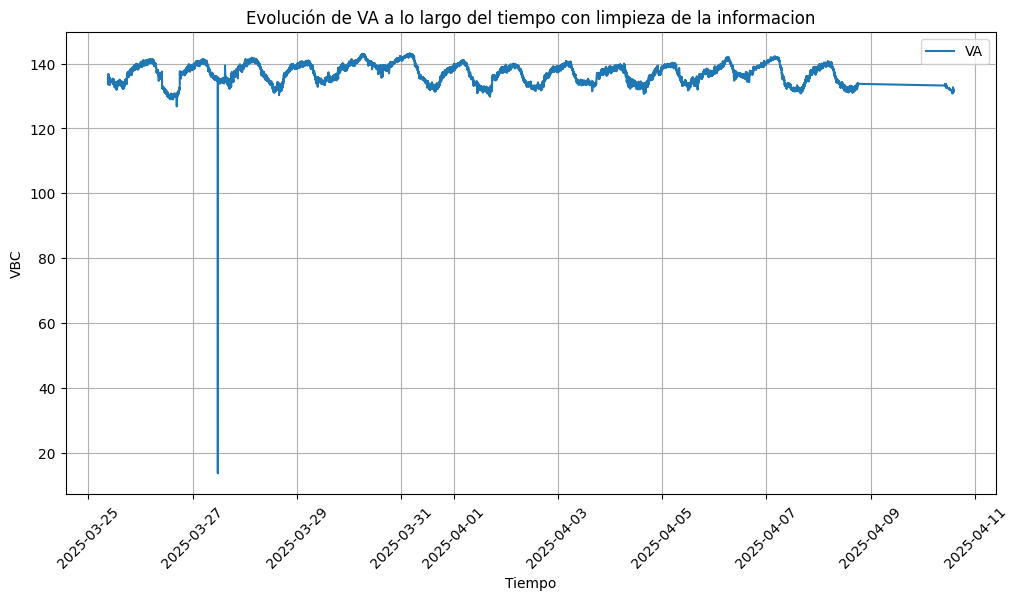

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supón que tienes el DataFrame `df` con un índice temporal
# Ver la estructura del índice de tiempo
print(df_cleaned.index)

# Graficar alguna variable (por ejemplo, 'VBC') para ver su evolución en el tiempo
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned.index, df_cleaned['VA'], label='VA')
plt.xlabel('Tiempo')
plt.ylabel('VBC')
plt.title('Evolución de VA a lo largo del tiempo con limpieza de la informacion')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


DatetimeIndex(['2025-03-25 11:00:01', '2025-03-25 11:00:09',
               '2025-03-25 11:00:23', '2025-03-25 11:00:24',
               '2025-03-25 11:00:30', '2025-03-25 11:00:34',
               '2025-03-25 11:01:02', '2025-03-25 11:01:09',
               '2025-03-25 11:01:23', '2025-03-25 11:01:25',
               ...
               '2025-04-08 09:58:14', '2025-04-08 09:58:15',
               '2025-04-08 09:58:17', '2025-04-08 09:58:19',
               '2025-04-08 09:58:59', '2025-04-08 09:59:14',
               '2025-04-08 09:59:15', '2025-04-08 09:59:16',
               '2025-04-08 09:59:17', '2025-04-08 09:59:20'],
              dtype='datetime64[ns]', name='ts', length=130672, freq=None)


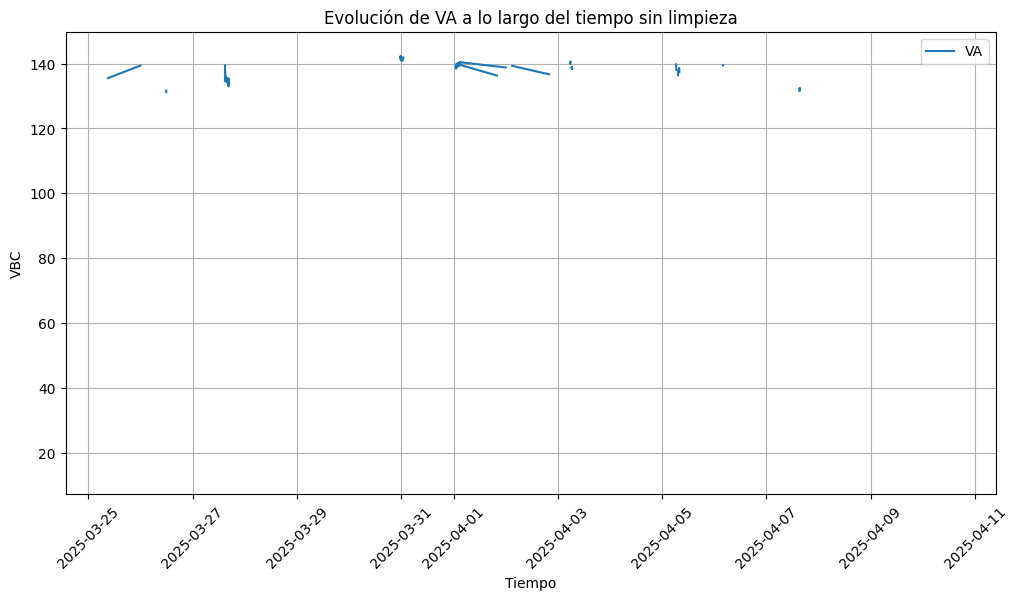

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supón que tienes el DataFrame `df` con un índice temporal
# Ver la estructura del índice de tiempo
print(final_df.index)

# Graficar alguna variable (por ejemplo, 'VBC') para ver su evolución en el tiempo
plt.figure(figsize=(12, 6))
plt.plot(final_df.index, final_df['VA'], label='VA')
plt.xlabel('Tiempo')
plt.ylabel('VBC')
plt.title('Evolución de VA a lo largo del tiempo sin limpieza')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()